# TODO: Dog Breed Classifier
**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [ ]:
# TODO: Install any packages that you might need

In [1]:
!pip install smdebug
!pip install s3fs

  Using cached fsspec-2024.10.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.10.0-py3-none-any.whl (179 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.6.0
ERROR: Cannot uninstall fsspec 2023.6.0, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps fsspec==2023.6.0'.


In [3]:
!pip install importlib-metadata

In [4]:
import sagemaker
import boto3

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [ ]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2024-12-07 13:32:00--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.193.16, 52.219.194.96, 52.219.113.64, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.193.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  3.72MB/s    in 3m 28s  

2024-12-07 13:35:29 (5.19 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  

In [10]:
#TODO: Fetch and upload the data to AWS S3
BUCKET = 'sab-project3-dogs'
role = sagemaker.get_execution_role()
session = sagemaker.Session()
s3_client = boto3.client('s3')

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [ ]:
!aws s3 sync ./dogImages/train s3://{BUCKET}/train
!aws s3 sync ./dogImages/test s3://{BUCKET}/test
!aws s3 sync ./dogImages/valid s3://{BUCKET}/valid

upload: dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg to s3://sab-project3-dogs/train/001.Affenpinscher/Affenpinscher_00001.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00002.jpg to s3://sab-project3-dogs/train/001.Affenpinscher/Affenpinscher_00002.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00004.jpg to s3://sab-project3-dogs/train/001.Affenpinscher/Affenpinscher_00004.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00008.jpg to s3://sab-project3-dogs/train/001.Affenpinscher/Affenpinscher_00008.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00007.jpg to s3://sab-project3-dogs/train/001.Affenpinscher/Affenpinscher_00007.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00006.jpg to s3://sab-project3-dogs/train/001.Affenpinscher/Affenpinscher_00006.jpg
upload: dogImages/train/001.Affenpinscher/Affenpinscher_00005.jpg to s3://sab-project3-dogs/train/001.Affenpinscher/Affenpinscher_00005.jpg
upload: dogImages/tr

In [25]:
#TODO: Declare your HP ranges, metrics etc.
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import HyperparameterTuner, CategoricalParameter

# Defining hypeparamters...
hyperparameter_ranges = {
    # 'learning_rate': CategoricalParameter([0.001, 0.00125, 0.00150]), # 25% increment
    'learning_rate': CategoricalParameter([0.00075 ,0.001]), # Best result has always being 0.001, downgrade 25%
    # 'epochs': CategoricalParameter([1, 5, 10]),
    # 'epochs': CategoricalParameter([1, 2, 3]),
    'epochs': CategoricalParameter([3, 5]),
    # 'optimizer': CategoricalParameter(['adam', 'sgd']),
    # 'optimizer': 'sgd', # Fixed, always better results than adam, directly passed to the estimator
    # 'train_batch_size': CategoricalParameter([25, 50, 100])
    'train_batch_size': CategoricalParameter([50, 100])
}

# Metric definitions
metric_definitions = [
    {
        'Name': 'Test Loss', 
        'Regex': 'Test Loss: ([0-9\\.]+)'
    },
    {
        'Name': 'Test Accuracy', 
        'Regex': 'Test Accuracy: ([0-9\\.]+)%'
        }
]


In [31]:
#TODO: Create estimators for your HPs
# Define the Pytorch estimator for training 
import time

estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name="hpo_tunning_dogs_category",
    role=role,
    py_version="py3",
    framework_version='1.4.0',
    instance_count=1,
    hyperparameters={
        'optimizer': 'adam',  # Fixed to 'adam'
    },
    instance_type='ml.m5.4xlarge',
    dependencies=['requirements.txt']
)
 
# let's do it
tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name='Test Loss',
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    max_jobs=8,
    max_parallel_jobs=4
)



In [ ]:
# TODO: Fit your estimator
import time

print(f"Starting")
start = time.time()
tuner.fit({'train': f"s3://{BUCKET}/train"}, wait=True)
end = time.time()

print(f"Total time taken for hyperparameter tuning: {end - start} seconds")

In [32]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.7 MB/s eta 0:00:00a 0:00:01


In [53]:
# TODO: Get the best estimators and the best HPs

# Create a SageMaker session
sagemaker_session = sagemaker.Session()

# List hyperparameter tuning jobs and filter for completed jobs
completed_tuning_jobs = sagemaker_session.sagemaker_client.list_hyper_parameter_tuning_jobs(
    StatusEquals='Completed'
)

# Print the names of the completed tuning jobs
print("Completed Hyperparameter Tuning Jobs:")
for job in completed_tuning_jobs['HyperParameterTuningJobSummaries']:
    print(f"- {job['HyperParameterTuningJobName']}")


Completed Hyperparameter Tuning Jobs:
- pytorch-training-230303-0254
- pytorch-training-230228-1100
- pytorch-training-230227-1323


In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from sagemaker.analytics import HyperparameterTuningJobAnalytics


best_jobs = []


for job in completed_tuning_jobs['HyperParameterTuningJobSummaries']:
    job_name = job['HyperParameterTuningJobName']
    # Filter the dataframe for the current job
    tuning_job_analytics = HyperparameterTuningJobAnalytics(job_name)
    df = tuning_job_analytics.dataframe()
    print(df.head())
    print("---------")
    # job_df = df[df['TrainingJobName'] == job_name]
    
    # # Get the row with the minimum FinalObjectiveValue (i.e., the best result)
    best_row = df.loc[df['FinalObjectiveValue'].idxmin()]
    
    # # Extract the best hyperparameters for this job
    best_hyperparameters = best_row[['batch_size', 'lr','FinalObjectiveValue']]  # Adjust if you have more hyperparameters
    best_jobs.append({'job_name': job_name, 'best_hyperparameters': best_hyperparameters})

# Print the best hyperparameters for each job
for job in best_jobs:
    print(f"Best hyperparameters for job {job['job_name']}:")
    print(job['best_hyperparameters'])

  batch_size        lr                            TrainingJobName  \
0       "32"  0.001378  pytorch-training-230303-0254-001-88e78775   

  TrainingJobStatus  FinalObjectiveValue         TrainingStartTime  \
0         Completed                149.0 2023-03-03 02:55:22+00:00   

            TrainingEndTime  TrainingElapsedTimeSeconds  
0 2023-03-03 03:11:38+00:00                       976.0  
---------
  batch_size        lr                            TrainingJobName  \
0       "32"  0.013671  pytorch-training-230228-1100-001-73c1ba07   

  TrainingJobStatus  FinalObjectiveValue         TrainingStartTime  \
0         Completed                121.0 2023-02-28 11:01:43+00:00   

            TrainingEndTime  TrainingElapsedTimeSeconds  
0 2023-02-28 11:17:58+00:00                       975.0  
---------
  batch_size        lr                            TrainingJobName  \
0       "32"  0.082775  pytorch-training-230227-1323-001-440b8f3a   

  TrainingJobStatus  FinalObjectiveValue         

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Convert the list of best_jobs to a DataFrame
best_jobs_df = pd.DataFrame(best_jobs)

# Expand the 'best_hyperparameters' dictionary into separate columns
best_jobs_df = pd.concat([best_jobs_df.drop('best_hyperparameters', axis=1), 
                          best_jobs_df['best_hyperparameters'].apply(pd.Series)], axis=1)

print(best_jobs_df)



                       job_name batch_size        lr  FinalObjectiveValue
0  pytorch-training-230303-0254       "32"  0.001378                149.0
1  pytorch-training-230228-1100       "32"  0.013671                121.0
2  pytorch-training-230227-1323       "32"  0.082775                 55.0


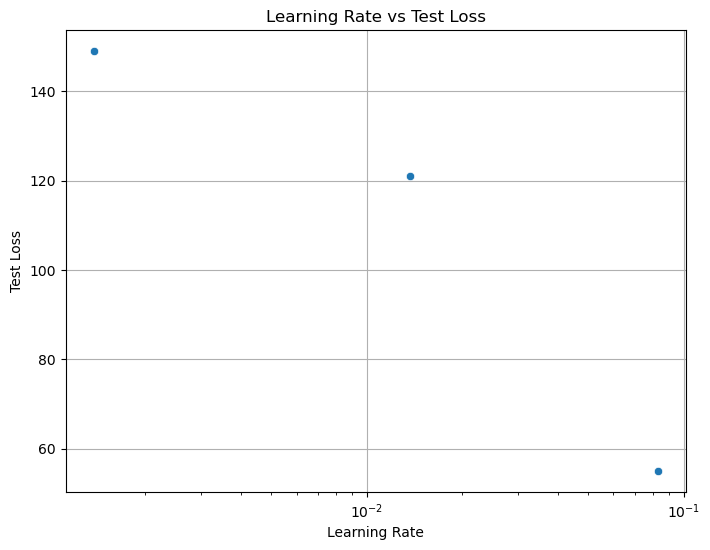

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
sns.scatterplot(x='lr', y='FinalObjectiveValue', data=best_jobs_df)

plt.title('Learning Rate vs Test Loss')
plt.xlabel('Learning Rate')
plt.ylabel('Test Loss')
plt.xscale('log') 
plt.grid(True)

plt.show()


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [63]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,  # Set your preferred interval
    framework_profile_params=FrameworkProfile(num_steps=10)  # Profile every 10 steps
)

# Define hooks for debugger
debugger_hook_config = DebuggerHookConfig(
    hook_parameters={"save_interval": "500"}  # Set interval as needed
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [89]:
# TODO: Create and fit an estimator

import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput


# Get the SageMaker execution role
role = get_execution_role()

# Define the estimator
estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="dogs-images-optimized-training",
    role=role,
    py_version="py3",
    framework_version="1.4.0",
    instance_count=1,
    instance_type='ml.m5.large',
    dependencies=['requirements.txt'],
    hyperparameters={
        "epochs": 5,  # from tuning
        "learning_rate": 0.001,  # from tuning
        "optimizer": "adam",  # from tuning
        "batch_size": 32,  # from tuning
    },
    rules=rules,  # If you have any rules (e.g., model monitoring, debugging)
    debugger_hook_config=debugger_hook_config,  # If you have debugging enabled
    profiler_config=profiler_config,  # If you have profiler enabled
    output_path=f"s3://{BUCKET}/training-output",  # S3 path for output
)

# Start the training job
#estimator.fit({'train': 's3://your-bucket/train-data'})  # Replace with your S3 path for training data
s3_train_data = f"s3://{BUCKET}/train/"
print (f"{s3_train_data}")

s3_valid_data = f"s3://{BUCKET}/valid/"

# Specify inputs
train_input = TrainingInput(s3_data=s3_train_data, content_type='application/x-image')
valid_input = TrainingInput(s3_data=s3_valid_data, content_type='application/x-image')

# Call fit with the S3 data
estimator.fit({'train': train_input, 'valid': valid_input})
# Fit the estimator with training data
#estimator.fit({"train": f"s3://{BUCKET}/train", "validation": valid_input, wait=True)

s3://sab-project3-dogs/train/


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: dogs-images-optimized-training-2024-12-07-23-27-15-330


2024-12-07 23:27:19 Starting - Starting the training job...
2024-12-07 23:27:45 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2024-12-07 23:28:25 Downloading - Downloading input data.........
2024-12-07 23:29:52 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-12-07 23:29:55,555 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-12-07 23:29:55,559 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2024-12-07 23:29:55,571 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-12-07 23:29:55,575 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-12-07 23:29:55,743 sagemaker-containers INFO     Modul

In [90]:
# TODO: Plot a debugging output.
# TODO: Plot a debugging output.
from smdebug.trials import create_trial

# Create a Debugger trial to access metrics
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print("Available Tensors:", trial.tensor_names())
print("Available steps:", trial.tensor("CrossEntropyLoss_output_0").steps())
print("Available values:", trial.tensor("CrossEntropyLoss_output_0").values())



[2024-12-08 01:24:07.513 d35e46982340:703 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-519574148523/dogs-images-optimized-training-2024-12-07-23-27-15-330/debug-output
[2024-12-08 01:24:09.011 d35e46982340:703 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-12-08 01:24:10.122 d35e46982340:703 INFO trial.py:210] Loaded all steps
Available Tensors: ['CrossEntropyLoss_output_0', 'gradient/ResNet_bn1.bias', 'gradient/ResNet_bn1.weight', 'gradient/ResNet_conv1.weight', 'gradient/ResNet_fc.bias', 'gradient/ResNet_fc.weight', 'gradient/ResNet_layer1.0.bn1.bias', 'gradient/ResNet_layer1.0.bn1.weight', 'gradient/ResNet_layer1.0.bn2.bias', 'gradient/ResNet_layer1.0.bn2.weight', 'gradient/ResNet_layer1.0.conv1.weight', 'gradient/ResNet_layer1.0.conv2.weight', 'gradient/ResNet_layer1.1.bn1.bias', 'gradient/ResNet_layer1.1.bn1.weight', 'gradient/ResNet_layer1.1.bn2.bias', 'gradient/ResNet_layer1.1.bn2.weight', 'gradient/ResNet_l

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

Yes there was an error caused by corrupted image, I had to modify the code to ignore those images.
The error was 
ExecuteUserScriptError:
Command "/opt/conda/bin/python3.6 train_model.py --batch_size 32 --epochs 5 --learning_rate 0.001 --optimizer adam"
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
#015  0%|          | 0.00/44.7M [00:00<?, ?B/s]#015 73%|ââââââââ  | 32.7M/44.7M [00:00<00:00, 343MB/s]#015100%|ââââââââââ| 44.7M/44.7M [00:00<00:00, 353MB/s]
ERROR:root:'NoneType' object has no attribute 'write'
Traceback (most recent call last):
  File "train_model.py", line 139, in <module>
    main(args)
  File "train_model.py", line 112, in main
    train(model, train_loader, criterion, optimizer, device)
  File "train_model.py", line 42, in train
    for inputs, labels in train_loader:
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 345, in __next__
    data = self._next_data()
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 385, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.6/site-packages/torchvision/datasets/folder.py", line 138, in __getitem__
    sample = self.loader(path)
  File "/opt/conda/lib/python3.6/site-packages/torchvision/datasets/folder.py", line 174, in default_loader
    return pil_loader(path)
  File "/opt/conda/lib/python3.6/site-packages/torchvision/datasets/folder.py", line 157, in pil_loader
    return img.convert('RGB')
  File "/opt/conda/lib/python3.6/site-packages/PIL/Image.py", line 904, in convert
    self.load()
  File "/opt/conda/lib/python3.6/site-packages/PIL/ImageFile.py", line 260, in load
    "image file is truncated "
OSError: image file is truncated (150 bytes not processed)

PoorWeightInitialization: IssuesFound

The solution was to ignore Truncated Images: Modify the dataset loader to ignore corrupted images by wrapping the loading logic in a try-except
I set ImageFile.LOAD_TRUNCATED_IMAGES to True globally. This allows Pillow to open truncated images without raising an
error

from PIL import ImageFile
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


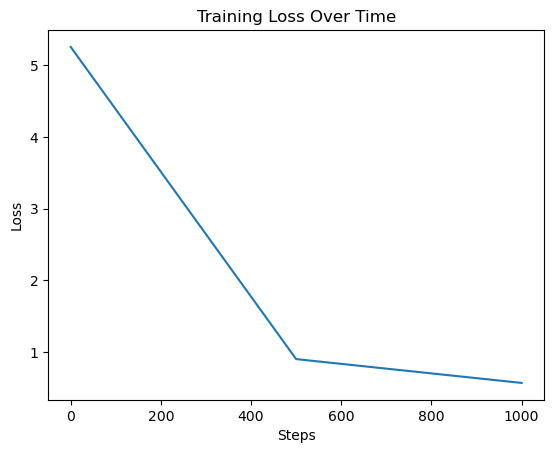

In [91]:
# TODO: Display the profiler output
# Plot loss or any other relevant metric
import matplotlib.pyplot as plt

# Extract the steps and corresponding loss values from the dictionary
steps = list(trial.tensor("CrossEntropyLoss_output_0").values().keys())
values = list(trial.tensor("CrossEntropyLoss_output_0").values().values())

# Plotting the data
import matplotlib.pyplot as plt

plt.plot(steps, values)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.show()

## Model Deploying

In [104]:
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.predictor import Predictor

jpeg_serializer = IdentitySerializer(content_type="image/jpeg")
json_deserializer = JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [117]:
# TODO: Deploy your model to an endpoint
import sagemaker
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorchModel

model_path = 's3://sab-project3-dogs/training-output/dogs-images-optimized-training-2024-12-07-23-27-15-330/output/model.tar.gz'
role = get_execution_role()
print("model name" + model_path)

pytorch_model = PyTorchModel(
    model_data=model_path,
    role=role,
    entry_point='inference.py',
    py_version='py3',
    framework_version='1.4',
    predictor_cls=ImagePredictor,
    dependencies=["requirements.txt"]
)

predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large' 
)
print("Endpoint deployed:", predictor.endpoint_name)


model names3://sab-project3-dogs/training-output/dogs-images-optimized-training-2024-12-07-23-27-15-330/output/model.tar.gz


INFO:sagemaker:Repacking model artifact (s3://sab-project3-dogs/training-output/dogs-images-optimized-training-2024-12-07-23-27-15-330/output/model.tar.gz), script artifact (None), and dependencies (['requirements.txt']) into single tar.gz file located at s3://sagemaker-us-east-1-519574148523/pytorch-inference-2024-12-08-02-57-55-900/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-12-08-02-58-21-436
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-12-08-02-58-22-501
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-12-08-02-58-22-501


------!Endpoint deployed: pytorch-inference-2024-12-08-02-58-22-501


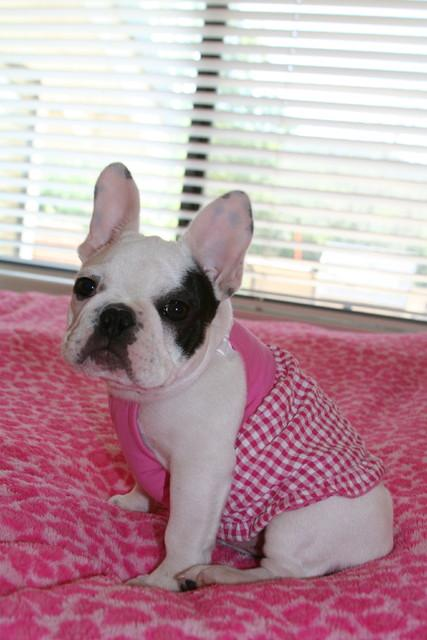

In [107]:
# TODO: Run an prediction on the endpoint
from PIL import Image
import io

image_path = "dogImages/train/069.French_bulldog/French_bulldog_04821.jpg"

with open(image_path, "rb") as f:
    payload = f.read()
        
type(payload)
Image.open(io.BytesIO(payload))


In [127]:
from sagemaker import Session

print(predictor.endpoint_name)
predictor = ImagePredictor(endpoint_name=predictor.endpoint_name, sagemaker_session=Session())

# Read the image as bytes
with open(image_path, "rb") as f:
    img_bytes = f.read()

# Send the image for prediction
response = predictor.predict(img_bytes)

print(response)

pytorch-inference-2024-12-08-02-58-22-501
{'predicted_label': '069', 'class_name': 'French_bulldog'}


In [122]:
predictor.delete_endpoint()


INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2024-12-08-02-58-22-501
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2024-12-08-02-58-22-501
